In [10]:
import os
import numpy as np
import pandas as pd
from matplotlib import cm
from tqdm import tqdm
import json
import anndata as ad

import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import squidpy as sq

from scipy.stats import pearsonr
import scipy.sparse

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [11]:
adata = sc.read_h5ad("/data/projects/robin/segmentation/new-slide-glom-periglom-ps/adata_with_polygons.h5ad")

In [24]:
# np.transpose(adata.obs)
adata.obs

x             y          z  \
cell_CR9fbacb852-116379-1-0-0-0-0-0   626.821432  17200.018200  26.991452   
cell_CR9fbacb852-116398-1-0-0-0-0-0   601.942038  17225.828680  29.601866   
cell_CR9fbacb852-116406-1-0-0-0-0-0   585.363261  17240.791579  32.168300   
cell_CR9fbacb852-116417-1-0-0-0-0-0   599.365954  17233.767857  30.226418   
cell_CR9fbacb852-116420-1-0-0-0-0-0   585.227809  17251.844000  29.607989   
...                                          ...           ...        ...   
cell_CR9fbacb852-343249-1            7437.606486   2441.129181  37.654304   
cell_CR9fbacb852-344028-1            6420.307371   2801.506047  39.312054   
cell_CR9fbacb852-344134-1            7426.221879   2851.256139  37.564034   
cell_CR9fbacb852-344280-1            7478.337415   2462.420563  34.261774   
cell_CR9fbacb852-344416-1            7380.969613   2642.821607  38.622404   

                                     cluster  n_transcripts  density  \
cell_CR9fbacb852-116379-1-0-0-0-0-0        3             10   1.1550   
cell_CR9fbacb852-116398-1-0-0-0-0-0        1             25   0.7076   
cell_CR9fbacb852-116406-1-0-0-0-0-0        1             19   0.9916   
cell_CR9fbacb852-116417-1-0-0-0-0-0        1             28   1.5580   
cell_CR9fbacb852-116420-1-0-0-0-0-0        1             21   1.5910   
...                                      ...            ...      ...   
cell_CR9fbacb852-343249-1                  4             21   1.7300   
cell_CR9fbacb852-344028-1                  1             17   2.0490   
cell_CR9fbacb852-344134-1                  4             28   0.5159   
cell_CR9fbacb852-344280-1                  4             41   1.6890   
cell_CR9fbacb852-344416-1                  4             15   2.0910   

                                     elongation    area  avg_confidence  \
cell_CR9fbacb852-116379-1-0-0-0-0-0      19.190   8.660          0.9818   
cell_CR9fbacb852-116398-1-0-0-0-0-0       3.957  35.330          0.9876   
cell_CR9fbacb852-116406-1-0-0-0-0-0       2.468  19.160          0.9974   
cell_CR9fbacb852-116417-1-0-0-0-0-0       2.934  17.970          0.9977   
cell_CR9fbacb852-116420-1-0-0-0-0-0       1.404  13.200          0.9981   
...                                         ...     ...             ...   
cell_CR9fbacb852-343249-1                 2.101  12.140          0.9980   
cell_CR9fbacb852-344028-1                 3.232   8.296          0.9983   
cell_CR9fbacb852-344134-1                 2.730  54.270          0.9952   
cell_CR9fbacb852-344280-1                 9.127  24.270          0.9982   
cell_CR9fbacb852-344416-1                 4.592   7.173          0.9983   

                                     avg_assignment_confidence  ...  \
cell_CR9fbacb852-116379-1-0-0-0-0-0                     0.9560  ...   
cell_CR9fbacb852-116398-1-0-0-0-0-0                     0.9080  ...   
cell_CR9fbacb852-116406-1-0-0-0-0-0                     1.0000  ...   
cell_CR9fbacb852-116417-1-0-0-0-0-0                     0.9500  ...   
cell_CR9fbacb852-116420-1-0-0-0-0-0                     1.0000  ...   
...                                                        ...  ...   
cell_CR9fbacb852-343249-1                               0.7352  ...   
cell_CR9fbacb852-344028-1                               0.7882  ...   
cell_CR9fbacb852-344134-1                               0.6000  ...   
cell_CR9fbacb852-344280-1                               0.7439  ...   
cell_CR9fbacb852-344416-1                               0.7467  ...   

                                     nichepca_domain_tuned  nichepca_glom_no  \
cell_CR9fbacb852-116379-1-0-0-0-0-0                  Other             Other   
cell_CR9fbacb852-116398-1-0-0-0-0-0                  Other             Other   
cell_CR9fbacb852-116406-1-0-0-0-0-0                  Other             Other   
cell_CR9fbacb852-116417-1-0-0-0-0-0                  Other             Other   
cell_CR9fbacb852-116420-1-0-0-0-0-0                  Other             Other   
...                    

In [13]:
adata = adata[adata.obs['sample'] != 'X1_slide2']
adata = adata[adata.obs['is_in_polygon']]

In [14]:
disease_set = adata.obs['Disease'].unique()
disease_set

['Cntrl', 'ANCA', 'GBM', 'SLE']
Categories (4, object): ['Cntrl', 'SLE', 'ANCA', 'GBM']

In [25]:
disease_order = ['Cntrl', 'SLE', 'ANCA', 'GBM']
df = adata.obs
df['label'] = pd.Categorical(df['Disease'], categories=disease_order, ordered=True)

In [26]:
df[['Disease' , 'Ki67_prot']].groupby('Disease').agg('mean')

Ki67_prot
Disease           
Cntrl     0.071151
SLE       0.889105
ANCA      1.516750
GBM       8.808657

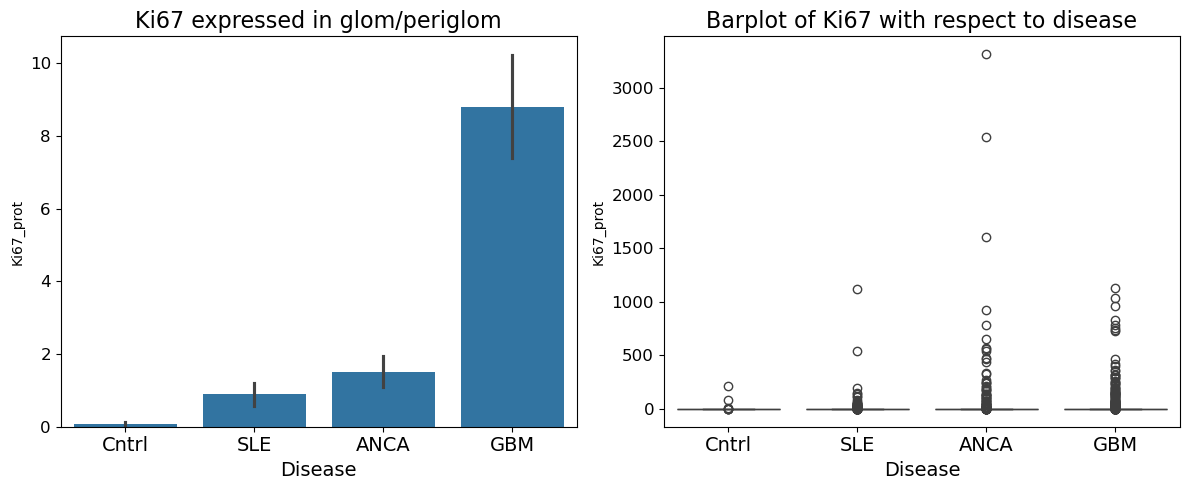

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))


ch = 'Ki67_prot'
label  = 'Disease'
sns.barplot(x=label, y=ch, data=df, ax=axes[0], errorbar='se', order=disease_order)
axes[0].set_title('Ki67 expressed in glom/periglom', fontsize=16)
axes[0].set_xlabel('Disease', fontsize=14)
# axes[0].set_ylabel('x', fontsize=14)
axes[0].tick_params(axis='x', labelsize=14)
axes[0].tick_params(axis='y', labelsize=12)

sns.boxplot(x=label, y=ch, data=df, ax=axes[1], order=disease_order)
axes[1].set_title('Barplot of Ki67 with respect to disease', fontsize=16)
axes[1].set_xlabel('Disease', fontsize=14)
# axes[1].set_ylabel('x', fontsize=14)
axes[1].tick_params(axis='x', labelsize=14)
axes[1].tick_params(axis='y', labelsize=12)


plt.tight_layout()
plt.show()

In [17]:
df = df.reset_index(drop=True)
df

x             y          z  cluster  n_transcripts  density  \
0     8144.040834  16277.815017  23.841296        4             29   1.7640   
1     8159.262823  16261.916967  25.886595        1             30   0.8641   
2     8144.195701  16290.583178  24.225777        4            101   2.9070   
3     8192.604171  16250.107725  27.897920        1             80   2.2730   
4     8144.819986  16305.816510  25.977430        4            105   1.3460   
...           ...           ...        ...      ...            ...      ...   
1798  6298.832975   2771.171592  39.646133        4             12   3.3430   
1799  7177.630189   2292.395295  38.123750        4             19   1.4130   
1800  6205.432373   1881.687145  37.128955        1             11   0.6159   
1801  7445.480690   2412.013745  35.699197        4             20   1.1610   
1802  7352.698877   2616.240542  36.302531        4             31   0.8397   

      elongation   area  avg_confidence  avg_assignment_confidence  ...  \
0          2.387  16.44          0.9971                     0.9593  ...   
1         28.630  34.72          0.9896                     0.9687  ...   
2          9.807  34.74          0.9978                     0.9566  ...   
3          4.720  35.19          0.9978                     0.9948  ...   
4          3.974  77.98          0.9967                     0.9598  ...   
...          ...    ...             ...                        ...  ...   
1798       1.517   3.59          0.9983                     0.8467  ...   
1799       4.763  13.45          0.9974                     0.7779  ...   
1800       1.746  17.86          0.9775                     0.8491  ...   
1801       7.309  17.22          0.9853                     0.8610  ...   
1802       3.015  36.92          0.9966                     0.6742  ...   

      nichepca_domain  nichepca_domain_tuned  nichepca_glom_no  CD44_prot  \
0               Other                  Other             Other          0   
1               Other                  Other             Other          0   
2               Other                  Other             Other          0   
3               Other                  Other             Other          0   
4               Other                  Other             Other          0   
...               ...                    ...               ...        ...   
1798            Glom.                  Glom.                 2          0   
1799            Glom.                  Glom.                 3          0   
1800            Other                  Other             Other          0   
1801            Other                  Other             Other          0   
1802            Glom.                  Glom.                 5         47   

      Ki67_prot                        glom_ID  \
0             0  Other_0011186_Cntrl_X1_slide2   
1             0  Other_0011186_Cntrl_X1_slide2   
2             0  Other_0011186_Cntrl_X1_slide2   
3             0  Other_0011186_Cntrl_X1_slide2   
4             0  Other_0011186_Cntrl_X1_slide2   
...         ...                            ...   
1798          0        2_0011186_SLE_X7_slide2   
1799          0        3_0011186_SLE_X7_slide2   
1800          0    Other_0011186_SLE_X7_slide2   
1801          0    Other_0011186_SLE_X7_slide2   
1802          0        5_0011186_SLE_X7_slide2   

                                        polygon_flags  is_in_polygon  \
0                           0_0011186_Cntrl_X1_slide2           True   
1                           0_0011186_Cntrl_X1_slide2           True   
2                           0_0011186_Cntrl_X1_slide2           True   
3                           0_0011186_Cntrl_X1_slide2           True   
4                           0_0011186_Cntrl_X1_slide2           True   
...                                               ...            ...   
1798                          2_0011186_SLE_X7_slide2           True   
1799                          3_0011186_SLE_X7_slide2           

In [18]:
df = df.reset_index(drop=True)
# df.insert(1, 'Ki67_prc', 0)
th = 1
df.loc[:, 'Ki67_prc'] = [1.0 if i>th else 0.0 for i in df['Ki67_prot']]
df['Ki67_prc'].sum()

16.0

In [20]:
# # fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ch = 'Ki67_prc'
# percent = df.groupby('label')[ch].mean() * 100
# percent = percent.reindex(disease_order)
# percent.plot(kind='bar', figsize=(8, 6))

# plt.title(f'Percentage of Ki67 > {th}')
# plt.xlabel('Disease')
# plt.ylabel('Percentage')
# plt.show()

(0.0, 1000.0)

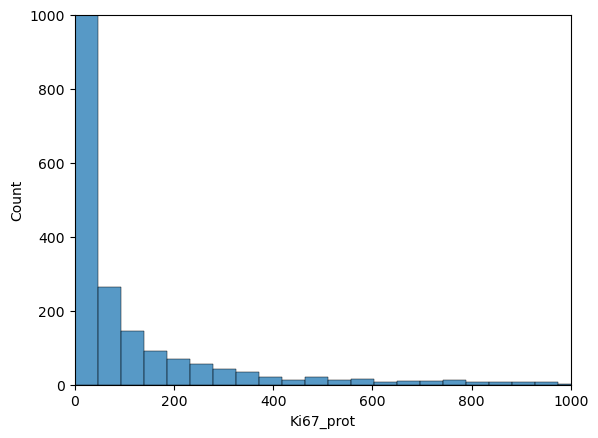

In [18]:
sns.histplot(adata.obs['Ki67_prot'], bins= 100)
plt.ylim([0, 1000])
plt.xlim([0, 1000])

In [31]:
for sample in adata.obs["sample"].unique():
    if sample != 'X7_slide2':
        continue
        
    adata_i = adata[adata.obs['sample'] == sample]
    condition = adata_i.obs.Disease.unique()[0]
    ll = []
    for _,row in adata_i.obs.iterrows():
        l = 'other'
        if row['is_in_polygon']:
            if row['celltype_l1'] == 'PEC':
                if row['Ki67_prot'] > 0:
                    l = 'PEC_with_Ki67_in_glom'
                else:
                    l = 'PEC_without_Ki67_in_glom'
        ll.append(l)
    adata_i.obs['in_polygon'] = ll
    
    adata_i.obs['in_polygon'] = adata_i.obs['in_polygon'].astype('category')

    
    colormap = {'PEC_with_Ki67_in_glom':'red', 
                'PEC_without_Ki67_in_glom' : 'blue', 
                'other': 'lightgray'}
    adata_i.obs['in_polygon'] = pd.Categorical(adata_i.obs['in_polygon'], 
                                       categories=list(colormap.keys()), 
                                       ordered=True)
    adata_i.uns['in_polygon_colors'] = list(colormap.values())
    
    adata_i.obs['size'] = [10 if i == 'PEC_with_Ki67_in_glom' else 10 for i in adata_i.obs['in_polygon']]
    
    n = (adata_i.obs['in_polygon'] == 'PEC_with_Ki67_in_glom').sum()

    # adata_i.obs['Ki67_thr'] = adata_i.obs['CD44_prot'] > 100
    fig, ax = plt.subplots(figsize=(20, 20))
    sc.pl.spatial(adata_i, 
                color = 'in_polygon',
                title=f"{sample}_{condition}_N={n}.",
                spot_size = adata_i.obs['size'],
                ax=ax,
                show=False)
    
    # plt.gca().invert_yaxis()
    plt.savefig(f"fig_slide2/sample_{sample}_.pdf")
    plt.close()
    print(condition)
    print("--")


SLE
--


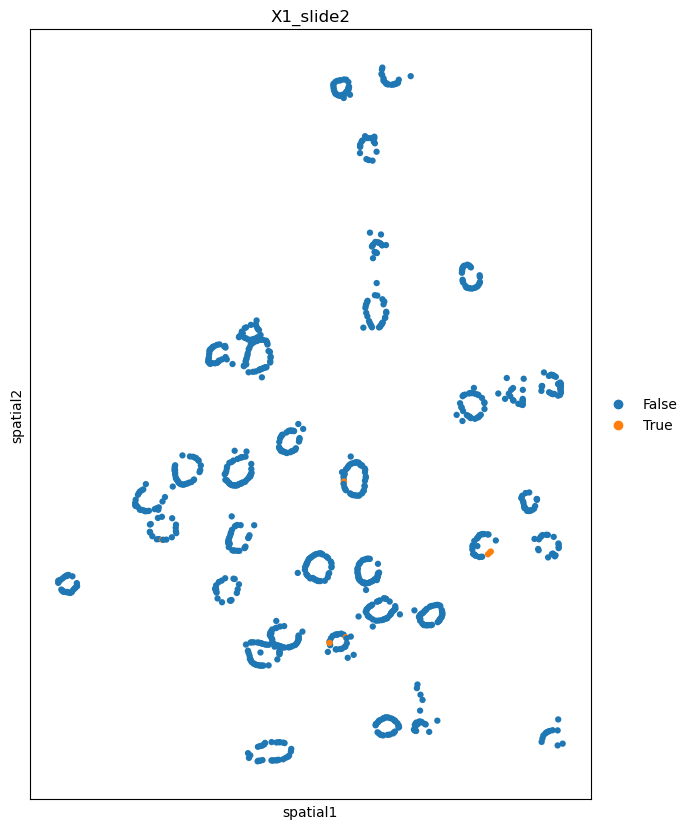

11
Cntrl
--


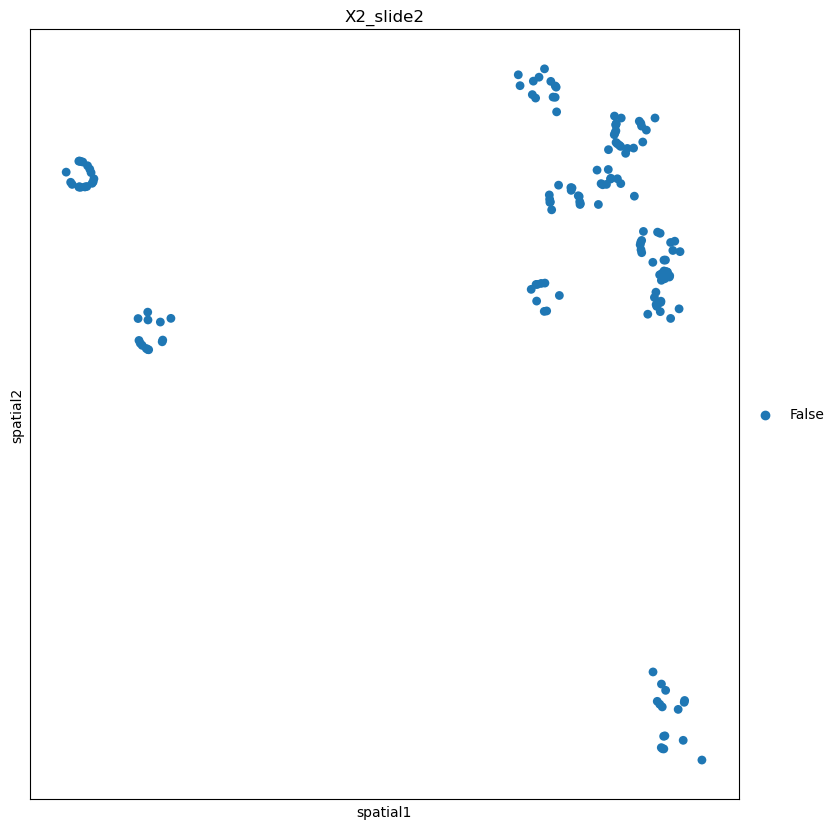

0
Cntrl
--


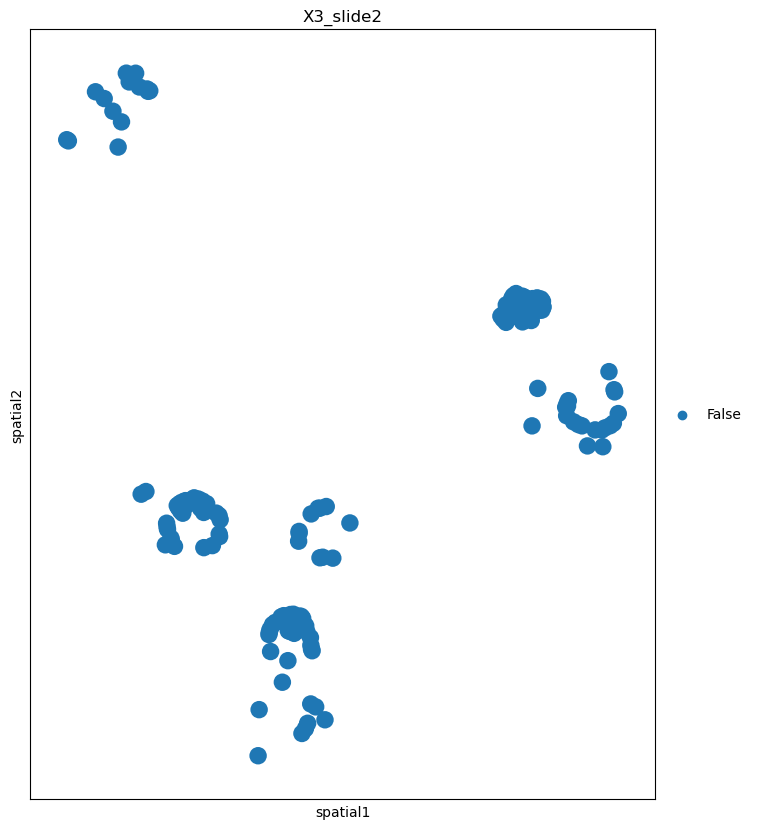

0
ANCA
--


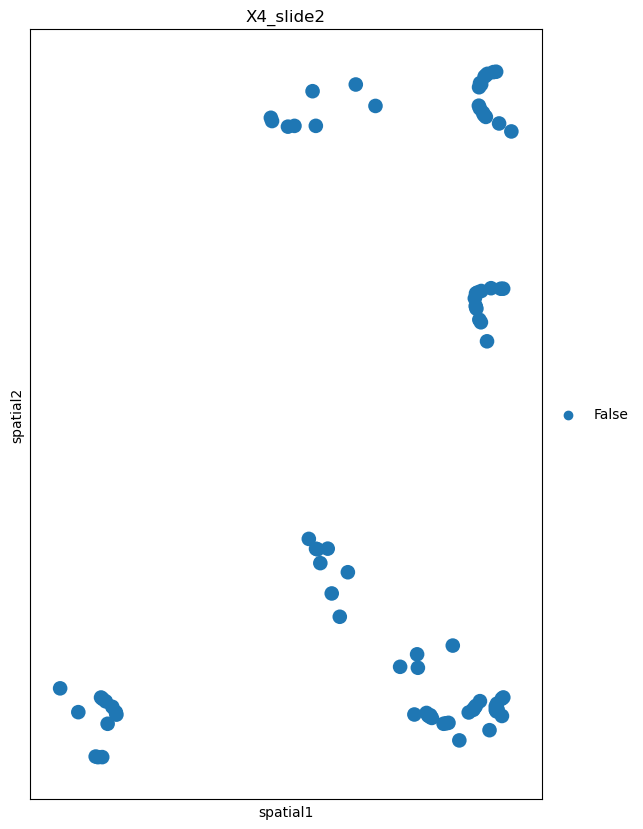

0
ANCA
--


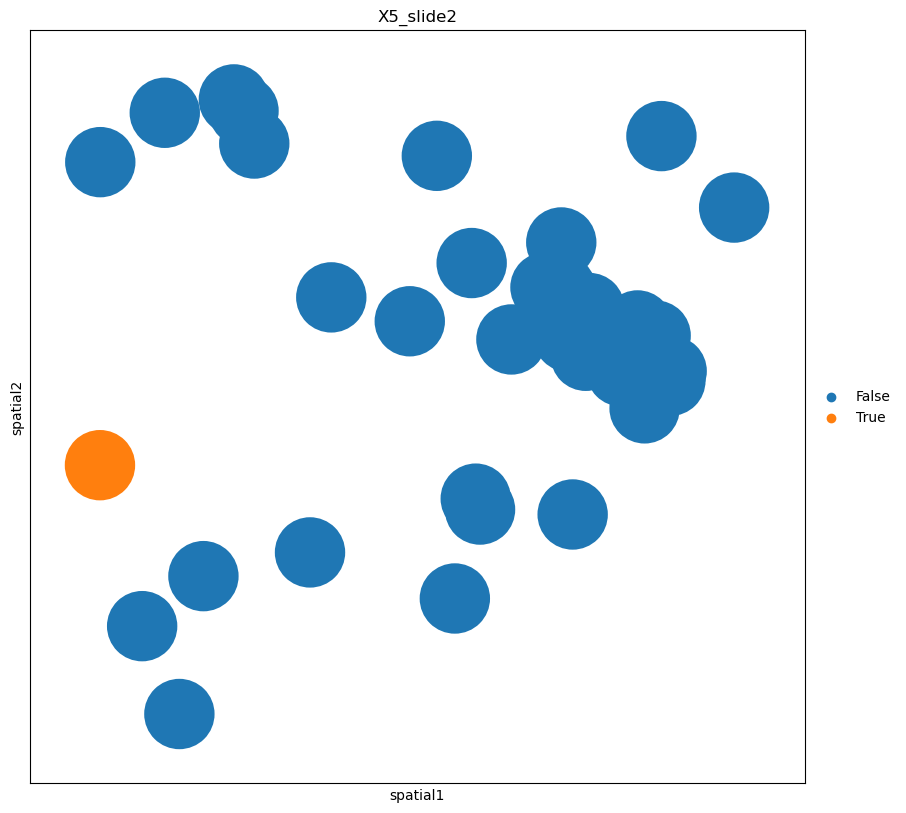

1
GBM
--


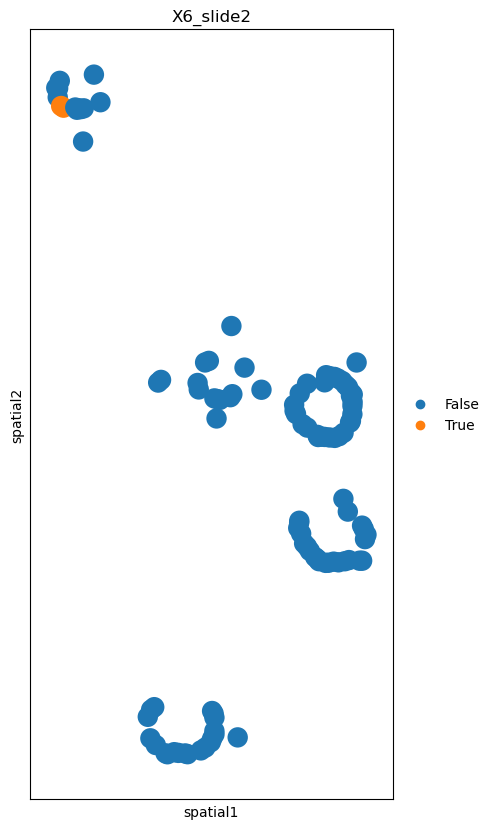

2
ANCA
--


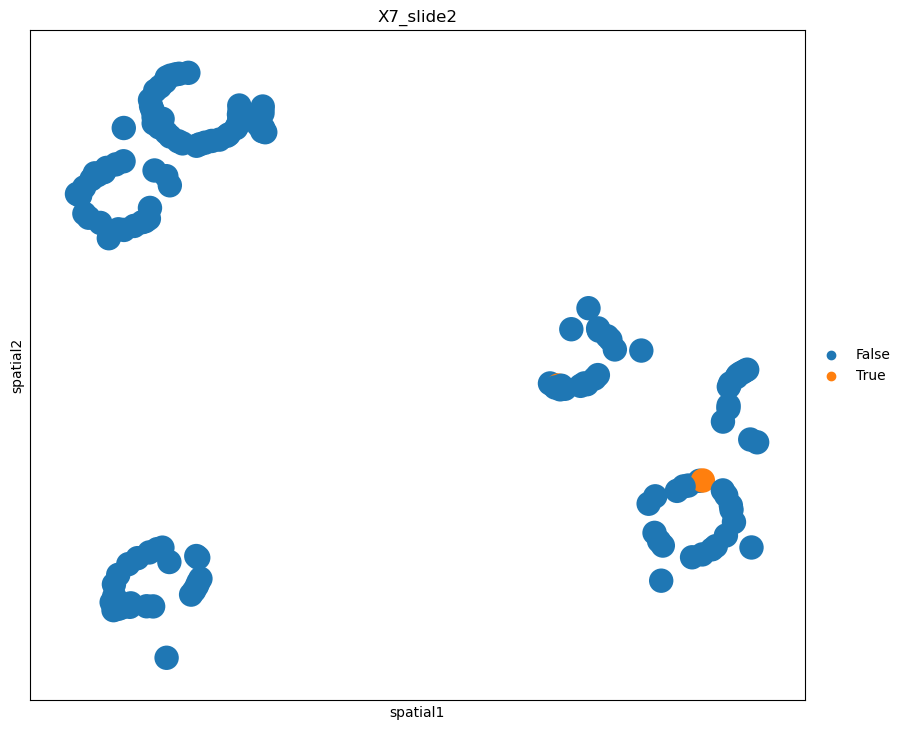

2
SLE
--


In [26]:
for sample in adata.obs["sample"].unique():
    adata_i = adata[adata.obs['sample'] == sample]
    condition = adata_i.obs.Disease.unique()[0]
    # adata_i = adata_i[adata_i.obs['celltype_l1'] == 'PEC']
    adata_i = adata_i[adata_i.obs['is_in_polygon']]
    adata_i.obs['Ki67_bin'] = adata_i.obs['Ki67_prot'] > 0
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    sc.pl.spatial(adata_i, 
                color = 'Ki67_bin',
                  title=sample,
                 spot_size = 50,
                 ax = ax)
    print(adata_i.obs['Ki67_bin'].sum())
    print(condition)
    print("--")

SLE


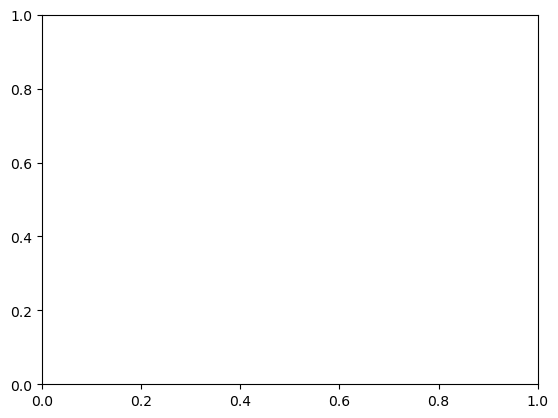

In [14]:
ax = plt.subplot(111)
sc.pl.spatial(adata_i, 
            color = 'in_polygon',
            title=f"{sample}_{condition}_N={n}.",
            spot_size = adata_i.obs['size'],
            show=False)

plt.gca().invert_yaxis()
plt.savefig(f"fig/sample_{sample}.pdf")
plt.close()
print(condition)

In [58]:
for sample in adata.obs["sample"].unique():
    adata_i = adata[adata.obs['sample'] == sample]
    condition = adata_i.obs.Disease.unique()[0]
    a = adata_i.obs['nichepca_glom_no'].unique()
    n_glom = np.max([int(i) for i in a[a != 'Other']])
    print(condition)
    print(n_glom)
    

Cntrl
35
Cntrl
10
ANCA
6
ANCA
6
GBM
0
ANCA
4
SLE
5


In [68]:
100 / (35 + 10)

2.2222222222222223

In [69]:
200 / 5

40.0

In [70]:
200 / (6 + 6 + 4)

12.5

In [71]:
100 / 1

100.0

In [6]:
adata_i = adata[adata.obs['sample'] == 'X7_slide2']

ValueError: When .uns['spatial'][library_id] does not exist, spot_size must be provided directly.

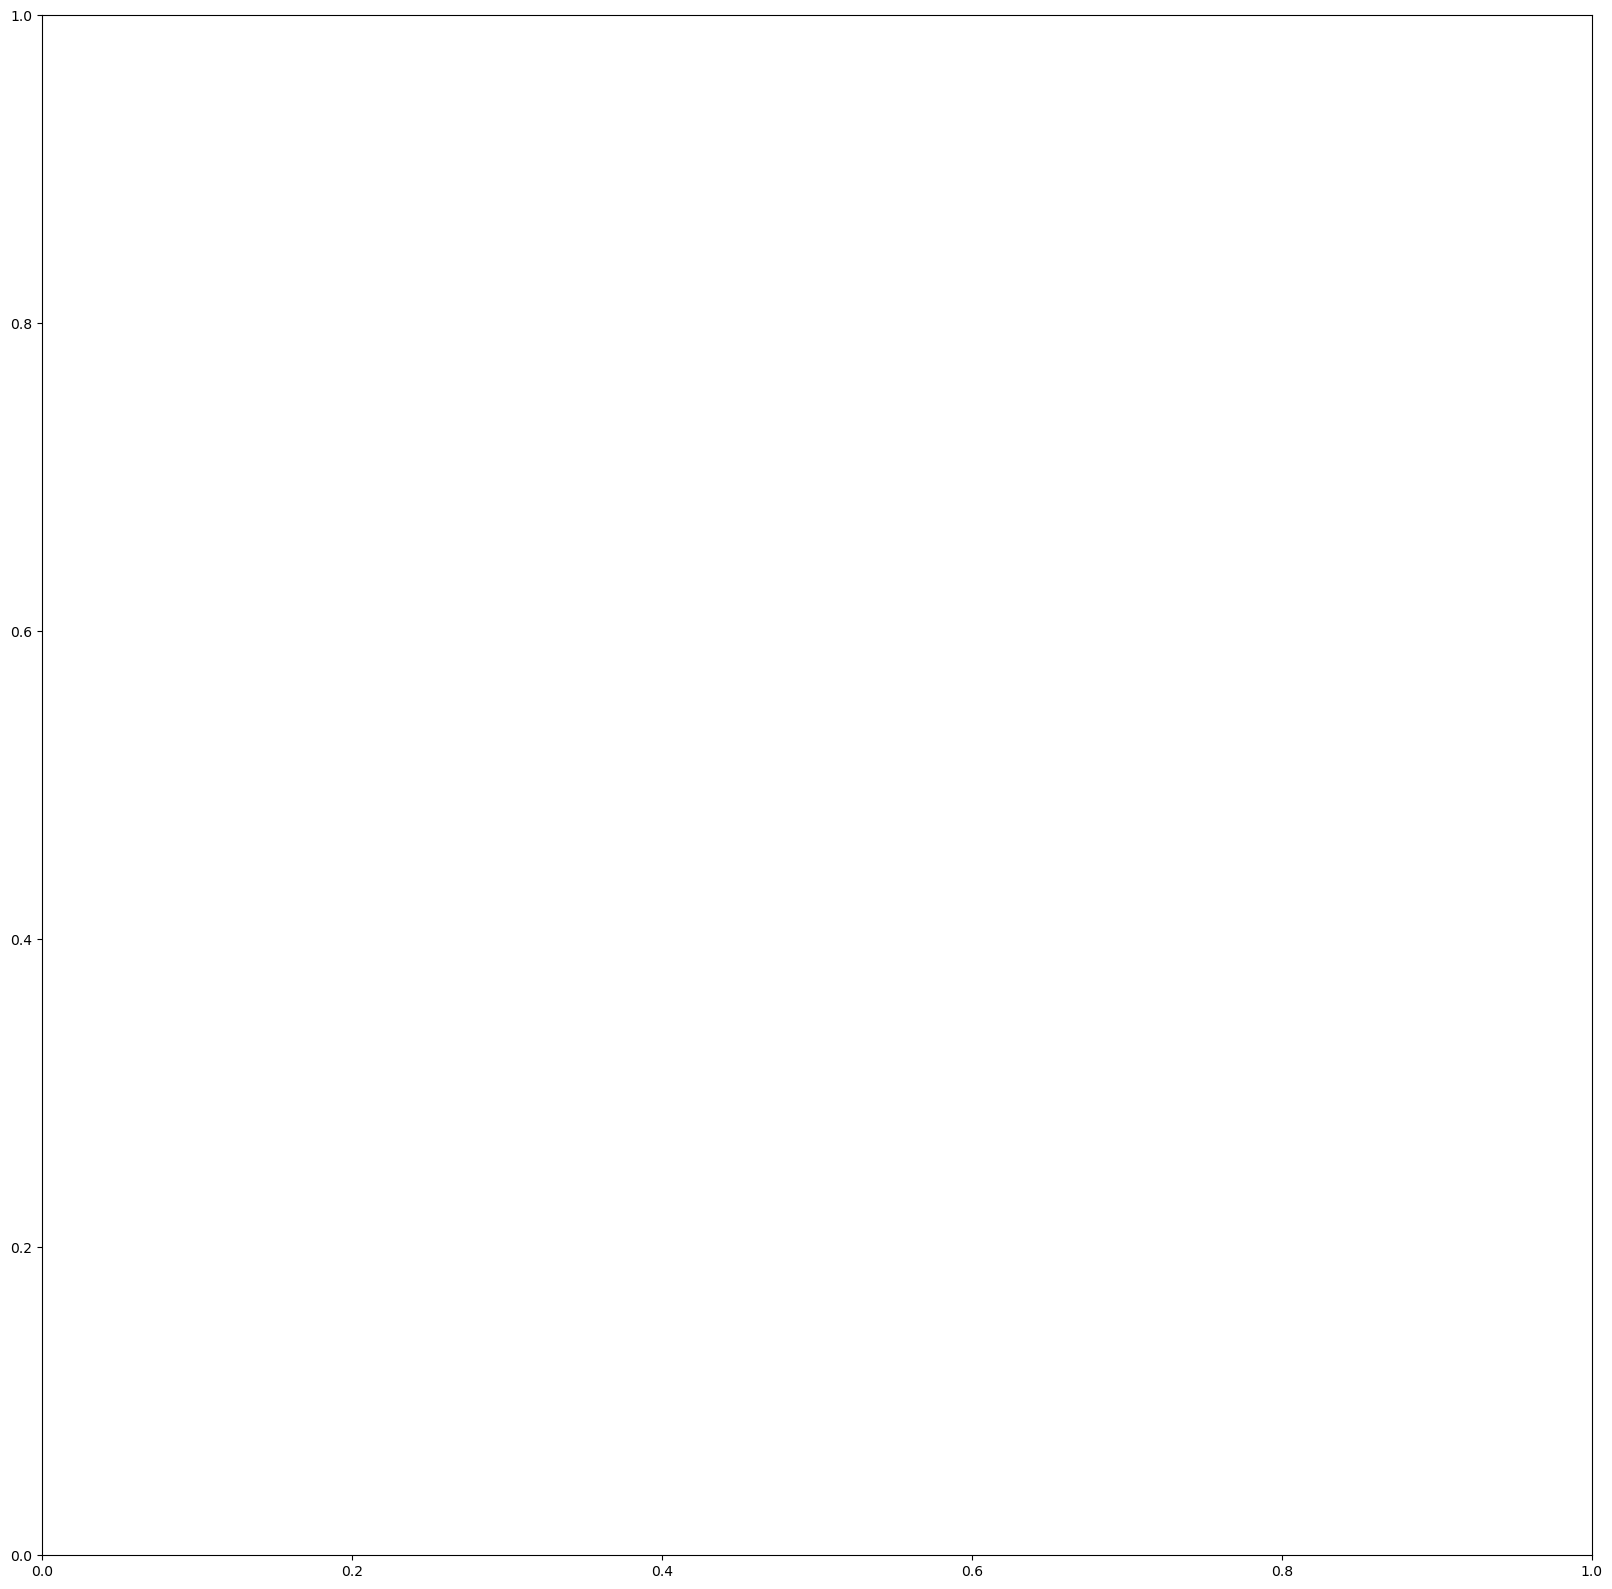

In [15]:
fig, ax = plt.subplots(figsize=(20, 20))
sc.pl.spatial(adata_i, 
            color = 'Ki67_prot',
            # title=f"{sample}_{condition}_N={n}.",
            # spot_size = adata_i.obs['size'],
            # ax=ax
             )

In [7]:
adata_i

x            y          z  cluster  \
cell_CR9fbacb852-12121-1   6032.449684  1076.280280  35.645237        2   
cell_CR9fbacb852-13226-1   5911.500627  1687.337272  37.135910        4   
cell_CR9fbacb852-13244-1   5918.133763  1680.444723  36.907107        1   
cell_CR9fbacb852-13263-1   5905.313392  1696.729325  36.513685        1   
cell_CR9fbacb852-13268-1   5908.233114  1700.804231  38.731637        1   
...                                ...          ...        ...      ...   
cell_CR9fbacb852-344135-1  7156.741758  2170.739595  38.006215        1   
cell_CR9fbacb852-344237-1  7246.011350  3333.079183  34.770267        4   
cell_CR9fbacb852-344280-1  7478.337415  2462.420563  34.261774        4   
cell_CR9fbacb852-344416-1  7380.969613  2642.821607  38.622404        4   
cell_CR9fbacb852-344461-1  7486.834270  1951.555960  38.974609        4   

                           n_transcripts  density  elongation    area  \
cell_CR9fbacb852-12121-1              49   0.9256       2.004  52.940   
cell_CR9fbacb852-13226-1             139   2.5070       1.961  55.450   
cell_CR9fbacb852-13244-1             115   1.2010       1.947  95.740   
cell_CR9fbacb852-13263-1              65   1.9960       2.155  32.560   
cell_CR9fbacb852-13268-1             219   3.2690       1.370  67.000   
...                                  ...      ...         ...     ...   
cell_CR9fbacb852-344135-1             19   0.9734       2.325  19.520   
cell_CR9fbacb852-344237-1             18   1.0500      25.290  17.140   
cell_CR9fbacb852-344280-1             41   1.6890       9.127  24.270   
cell_CR9fbacb852-344416-1             15   2.0910       4.592   7.173   
cell_CR9fbacb852-344461-1             10   6.2340      15.300   1.604   

                           avg_confidence  avg_assignment_confidence  ...  \
cell_CR9fbacb852-12121-1           0.9975                     0.9971  ...   
cell_CR9fbacb852-13226-1           0.9978                     0.9807  ...   
cell_CR9fbacb852-13244-1           0.9975                     0.9617  ...   
cell_CR9fbacb852-13263-1           0.9977                     0.8465  ...   
cell_CR9fbacb852-13268-1           0.9976                     0.9141  ...   
...                                   ...                        ...  ...   
cell_CR9fbacb852-344135-1          0.9967                     0.7937  ...   
cell_CR9fbacb852-344237-1          0.9914                     0.6889  ...   
cell_CR9fbacb852-344280-1          0.9982                     0.7439  ...   
cell_CR9fbacb852-344416-1          0.9983                     0.7467  ...   
cell_CR9fbacb852-344461-1          0.9980                     0.8700  ...   

                           nichepca_domain  nichepca_domain_tuned  \
cell_CR9fbacb852-12121-1             Other                  Other   
cell_CR9fbacb852-13226-1             Other                  Other   
cell_CR9fbacb852-13244-1             Other                  Other   
cell_CR9fbacb852-13263-1             Other                  Other   
cell_CR9fbacb852-13268-1             Other                  Other   
...                                    ...                    ...   
cell_CR9fbacb852-344135-1            Other                  Other   
cell_CR9fbacb852-344237-1            Other                  Other   
cell_CR9fbacb852-344280-1            Glom.                  Glom.   
cell_CR9fbacb852-344416-1            Glom.                  Glom.   
cell_CR9fbacb852-344461-1            Other                  Other   

                           nichepca_glom_no  CD44_prot  Ki67_prot  \
cell_CR9fbacb852-12121-1              Other          0          0   
cell_CR9fbacb852-13226-1              Other          2          0   
cell_CR9fbacb852-13244-1              Other          0          0   
cell_CR9fbacb852-13263-1              Other          0          0   
cell_CR9fbacb852-13268-1              Other          2          0   
...                                     ...        ...        ...   
cell_CR9fbacb852-34413

In [5]:
adata.obs['sample']

cell_CR9fbacb852-172697-0-0-0-0-0-0    X1_slide2
cell_CR9fbacb852-183840-0-0-0-0-0-0    X1_slide2
cell_CR9fbacb852-183965-0-0-0-0-0-0    X1_slide2
cell_CR9fbacb852-184398-0-0-0-0-0-0    X1_slide2
cell_CR9fbacb852-185040-0-0-0-0-0-0    X1_slide2
                                         ...    
cell_CR9fbacb852-344135-1              X7_slide2
cell_CR9fbacb852-344237-1              X7_slide2
cell_CR9fbacb852-344280-1              X7_slide2
cell_CR9fbacb852-344416-1              X7_slide2
cell_CR9fbacb852-344461-1              X7_slide2
Name: sample, Length: 289602, dtype: category
Categories (7, object): ['X1_slide2', 'X2_slide2', 'X3_slide2', 'X4_slide2', 'X5_slide2', 'X6_slide2', 'X7_slide2']